In [33]:
#Min kode så langt
import os
import numpy as np 
import pandas as pd 
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
warnings.filterwarnings("ignore")
pd.set_option("display.max_rows",None)
from sklearn import preprocessing
import matplotlib 
matplotlib.style.use('ggplot')
from sklearn.preprocessing import LabelEncoder

In [34]:
# Load energy data
energy_df = pd.read_csv('../data/energy_import_export.csv')

# Load solar self-consumption data
solar_df = pd.read_csv('../data/solar_self_consumption_main_building.csv')

# Load meteorological data
met_df = pd.read_csv('../data/met_data.csv')

In [35]:
energy_df.head()

,Energikilde,Retning,Målernavn,Måler-Id,Verdi,Tidspunkt
0,Elektrisitet,IMPORT,Hovedmåler,707057500038344962,19.80,2023-07-01 00:00
1,Elektrisitet,IMPORT,Hovedmåler,707057500042201572,35.10,2023-07-01 00:00
2,Elektrisitet,EXPORT,Hovedmåler,707057500042745649,0.00,2023-07-01 00:00
3,Elektrisitet,IMPORT,Hovedmåler,707057500085390523,27.44,2023-07-01 00:00
4,Elektrisitet,IMPORT,Hovedmåler,707057500042745649,27.50,2023-07-01 00:00


In [37]:
#Fjerner kolonner som ikke er nødvendige
energy_df = energy_df.drop(['Energikilde', 'Målernavn'], axis=1)
energy_df.head()

,Retning,Måler-Id,Verdi,Tidspunkt
0,IMPORT,707057500038344962,19.80,2023-07-01 00:00
1,IMPORT,707057500042201572,35.10,2023-07-01 00:00
2,EXPORT,707057500042745649,0.00,2023-07-01 00:00
3,IMPORT,707057500085390523,27.44,2023-07-01 00:00
4,IMPORT,707057500042745649,27.50,2023-07-01 00:00


In [38]:
solar_df.head()

,Unnamed: 0,starting_at,solar_consumption
0,1,2023-07-01,0.002687
1,2,2023-07-01 01:00:00,0.002750
2,3,2023-07-01 02:00:00,0.002937
3,4,2023-07-01 03:00:00,0.003062
4,5,2023-07-01 04:00:00,0.000035


In [39]:
#Fjerner kolonner som ikke er nødvendige
solar_df = solar_df.drop(['Unnamed: 0'], axis=1)
solar_df.head()

,starting_at,solar_consumption
0,2023-07-01,0.002687
1,2023-07-01 01:00:00,0.002750
2,2023-07-01 02:00:00,0.002937
3,2023-07-01 03:00:00,0.003062
4,2023-07-01 04:00:00,0.000035


In [40]:
met_df.head()

,property_id,starting_at,temperature,wind_speed,wind_direction,cloud_fraction,precipitation
0,4462,2024-09-05 04:00:00.000 +0000,15.4,0.4,218.5,0.2,0.0
1,4746,2024-09-05 04:00:00.000 +0000,17.1,4.4,14.2,0.0,0.0
2,10703,2024-09-05 04:00:00.000 +0000,14.4,1.0,273.9,0.0,0.0
3,10724,2024-09-05 04:00:00.000 +0000,15.6,1.9,10.3,0.0,0.0
4,4462,2024-09-05 03:00:00.000 +0000,15.3,0.6,255.3,0.7,0.0


In [41]:
# Konverterer alle tidskolonner til datetime

# Convert timestamp columns to datetime
energy_df['Tidspunkt'] = pd.to_datetime(energy_df['Tidspunkt'], format="mixed")
solar_df['starting_at'] = pd.to_datetime(solar_df['starting_at'], format='mixed')

# remove utc from the time string
met_df['starting_at'] = met_df['starting_at'].str.split('+').str[0]
met_df['starting_at'] = pd.to_datetime(met_df['starting_at'], format='mixed')


In [42]:
#Gir nye navn til alle kolonner for enklere referanse

# Rename columns for easier reference
energy_df.rename(columns={
    'Retning': 'direction',
    'Måler-Id': 'meter_id',
    'Verdi': 'value',
    'Tidspunkt': 'timestamp'
}, inplace=True)

# rename starting at to timestamp for solar_df and met_df
solar_df.rename(columns={
    'starting_at': 'timestamp'
}, inplace=True)
met_df.rename(columns={
    'starting_at': 'timestamp'
}, inplace=True)


In [43]:
#Legger til kolonne i energy_df med property_id som brukes i met_df

meter_property_mapping = {
    '707057500042745649': 10724, #main building
    '707057500038344962': 10703, # building A
    '707057500085390523': 4462, # building B
    '707057500042201572': 4746 # building C
}
# Strip any leading/trailing spaces in the 'meter_id' column

energy_df['meter_id'] = energy_df['meter_id'].astype(str)
energy_df['meter_id'] = energy_df['meter_id'].str.strip()

energy_df['property_id'] = energy_df['meter_id'].map(meter_property_mapping)

energy_df.tail()

,direction,meter_id,value,timestamp,property_id
54471,IMPORT,707057500038344962,27.40,2024-09-04 23:00:00,10703
54472,IMPORT,707057500042201572,31.50,2024-09-04 23:00:00,4746
54473,EXPORT,707057500042745649,0.00,2024-09-04 23:00:00,10724
54474,IMPORT,707057500085390523,27.76,2024-09-04 23:00:00,4462
54475,IMPORT,707057500042745649,38.60,2024-09-04 23:00:00,10724


In [44]:
#Lager en ny df med join av energy_df og met_df

merged_df = pd.merge(energy_df, met_df, on=['property_id', 'timestamp'], how='left')

merged_df.tail()

,direction,meter_id,value,timestamp,property_id,temperature,wind_speed,wind_direction,cloud_fraction,precipitation
54471,IMPORT,707057500038344962,27.40,2024-09-04 23:00:00,10703,16.2,1.4,281.6,0.4,0.0
54472,IMPORT,707057500042201572,31.50,2024-09-04 23:00:00,4746,18.2,4.8,14.4,0.0,0.0
54473,EXPORT,707057500042745649,0.00,2024-09-04 23:00:00,10724,17.4,1.8,356.1,0.9,0.0
54474,IMPORT,707057500085390523,27.76,2024-09-04 23:00:00,4462,15.6,0.9,243.3,0.9,0.0
54475,IMPORT,707057500042745649,38.60,2024-09-04 23:00:00,10724,17.4,1.8,356.1,0.9,0.0


In [45]:
#Sjekker om det er noen manglende verdier i merged_df

# Check for missing values
print("total number of rows", merged_df.shape[0])
print("rows missing weather data \n",merged_df.isnull().sum())

rows_with_missing_values = merged_df[merged_df.isnull().any(axis=1)]
rows_with_missing_values.head()

total number of rows 54476
rows missing weather data 
 direction           0
meter_id            0
value               0
timestamp           0
property_id         0
temperature       385
wind_speed        385
wind_direction    385
cloud_fraction    385
precipitation     385
dtype: int64


,direction,meter_id,value,timestamp,property_id,temperature,wind_speed,wind_direction,cloud_fraction,precipitation
29071,EXPORT,707057500042745649,0.0,2024-02-06 06:00:00,10724,NaN,NaN,NaN,NaN,NaN
29072,IMPORT,707057500038344962,37.4,2024-02-06 06:00:00,10703,NaN,NaN,NaN,NaN,NaN
29073,IMPORT,707057500042745649,37.8,2024-02-06 06:00:00,10724,NaN,NaN,NaN,NaN,NaN
29074,IMPORT,707057500042201572,46.4,2024-02-06 06:00:00,4746,NaN,NaN,NaN,NaN,NaN
29075,IMPORT,707057500085390523,34.4,2024-02-06 06:00:00,4462,NaN,NaN,NaN,NaN,NaN


In [46]:
#Vi ser at det mangler værdate for nærmere 400 rader. Vi fyller disse med verdier fra nærmeste tidspunkt
#Bruker interpolering for å fikse gapene
merged_df = merged_df.interpolate(method='linear', limit_direction='both')

# Check for missing values
print("total number of rows", merged_df.shape[0])
print("rows missing weather data \n",merged_df.isnull().sum())

total number of rows 54476
rows missing weather data 
 direction         0
meter_id          0
value             0
timestamp         0
property_id       0
temperature       0
wind_speed        0
wind_direction    0
cloud_fraction    0
precipitation     0
dtype: int64


In [47]:
#Lager df med import og export data

# Separate import (consumption) and export (production)
import_df = merged_df[merged_df['direction'] == 'IMPORT']
export_df = merged_df[merged_df['direction'] == 'EXPORT']

In [48]:
# For property_id 10724 (main building)
main_ID = 10724
main_building_import = import_df[import_df['property_id'] == main_ID]

main_building_export = export_df[export_df['property_id'] == main_ID]

# Merge with solar self-consumption data
main_building_df = pd.merge(main_building_import, solar_df, left_on='timestamp', right_on='timestamp', how='left')

# Replace NaN in solar_consumption with 0
#main_building_df['solar_consumption'].fillna(0, inplace=True)

# Calculate total consumption including self-consumed solar energy
#main_building_df['total_consumption'] = main_building_df['value'] + main_building_df['solar_consumption']




In [49]:
# Check for missing values
print("total number of rows", main_building_df.shape[0])
print("rows missing weather data \n",main_building_df.isnull().sum())

main_building_df.head()

total number of rows 10346
rows missing weather data 
 direction              0
meter_id               0
value                  0
timestamp              0
property_id            0
temperature            0
wind_speed             0
wind_direction         0
cloud_fraction         0
precipitation          0
solar_consumption    153
dtype: int64


,direction,meter_id,value,timestamp,property_id,temperature,wind_speed,wind_direction,cloud_fraction,precipitation,solar_consumption
0,IMPORT,707057500042745649,27.5,2023-07-01 00:00:00,10724,13.6,1.6,251.5,0.5,0.0,0.002687
1,IMPORT,707057500042745649,27.1,2023-07-01 01:00:00,10724,13.2,2.0,246.5,0.4,0.0,0.002750
2,IMPORT,707057500042745649,26.8,2023-07-01 02:00:00,10724,12.3,1.6,260.4,0.3,0.0,0.002937
3,IMPORT,707057500042745649,25.9,2023-07-01 03:00:00,10724,11.9,0.6,285.0,0.9,0.0,0.003062
4,IMPORT,707057500042745649,26.4,2023-07-01 04:00:00,10724,11.9,0.2,295.8,0.8,0.0,0.000035


In [50]:
#Tar en rask titt på radene som mangler soldata

rows_with_missing_solar_values = main_building_df[main_building_df.isnull().any(axis=1)]
rows_with_missing_solar_values.head()

,direction,meter_id,value,timestamp,property_id,temperature,wind_speed,wind_direction,cloud_fraction,precipitation,solar_consumption
3732,IMPORT,707057500042745649,45.3,2023-12-04 12:00:00,10724,-5.3,1.2,50.9,0.7,0.0,NaN
3733,IMPORT,707057500042745649,43.4,2023-12-04 13:00:00,10724,-5.3,0.9,13.6,0.9,0.0,NaN
3734,IMPORT,707057500042745649,44.4,2023-12-04 14:00:00,10724,-5.2,1.0,340.0,1.0,0.0,NaN
3735,IMPORT,707057500042745649,43.4,2023-12-04 15:00:00,10724,-5.2,0.6,13.2,0.2,0.0,NaN
3736,IMPORT,707057500042745649,46.5,2023-12-04 16:00:00,10724,-5.3,0.8,345.6,0.0,0.0,NaN


In [51]:

#Bruker interpolering for å fikse gapene
main_building_df = main_building_df.interpolate(method='linear', limit_direction='both')

# Check for missing values
print("total number of rows", main_building_df.shape[0])
print("rows missing weather data \n",main_building_df.isnull().sum())

total number of rows 10346
rows missing weather data 
 direction            0
meter_id             0
value                0
timestamp            0
property_id          0
temperature          0
wind_speed           0
wind_direction       0
cloud_fraction       0
precipitation        0
solar_consumption    0
dtype: int64


In [52]:
# Get import data for reference buildings
ref_buildings = [10703, 4462, 4746]
ref_buildings_df = import_df[import_df['property_id'].isin(ref_buildings)]

ref_buildings_df.head()

,direction,meter_id,value,timestamp,property_id,temperature,wind_speed,wind_direction,cloud_fraction,precipitation
0,IMPORT,707057500038344962,19.80,2023-07-01 00:00:00,10703,12.9,1.0,275.7,0.7,0.0
1,IMPORT,707057500042201572,35.10,2023-07-01 00:00:00,4746,15.2,3.9,247.0,0.2,0.0
3,IMPORT,707057500085390523,27.44,2023-07-01 00:00:00,4462,12.0,0.7,220.3,0.5,0.0
6,IMPORT,707057500085390523,21.52,2023-07-01 01:00:00,4462,11.9,0.7,179.6,0.9,0.0
9,IMPORT,707057500038344962,19.00,2023-07-01 01:00:00,10703,12.6,1.0,253.7,0.8,0.0


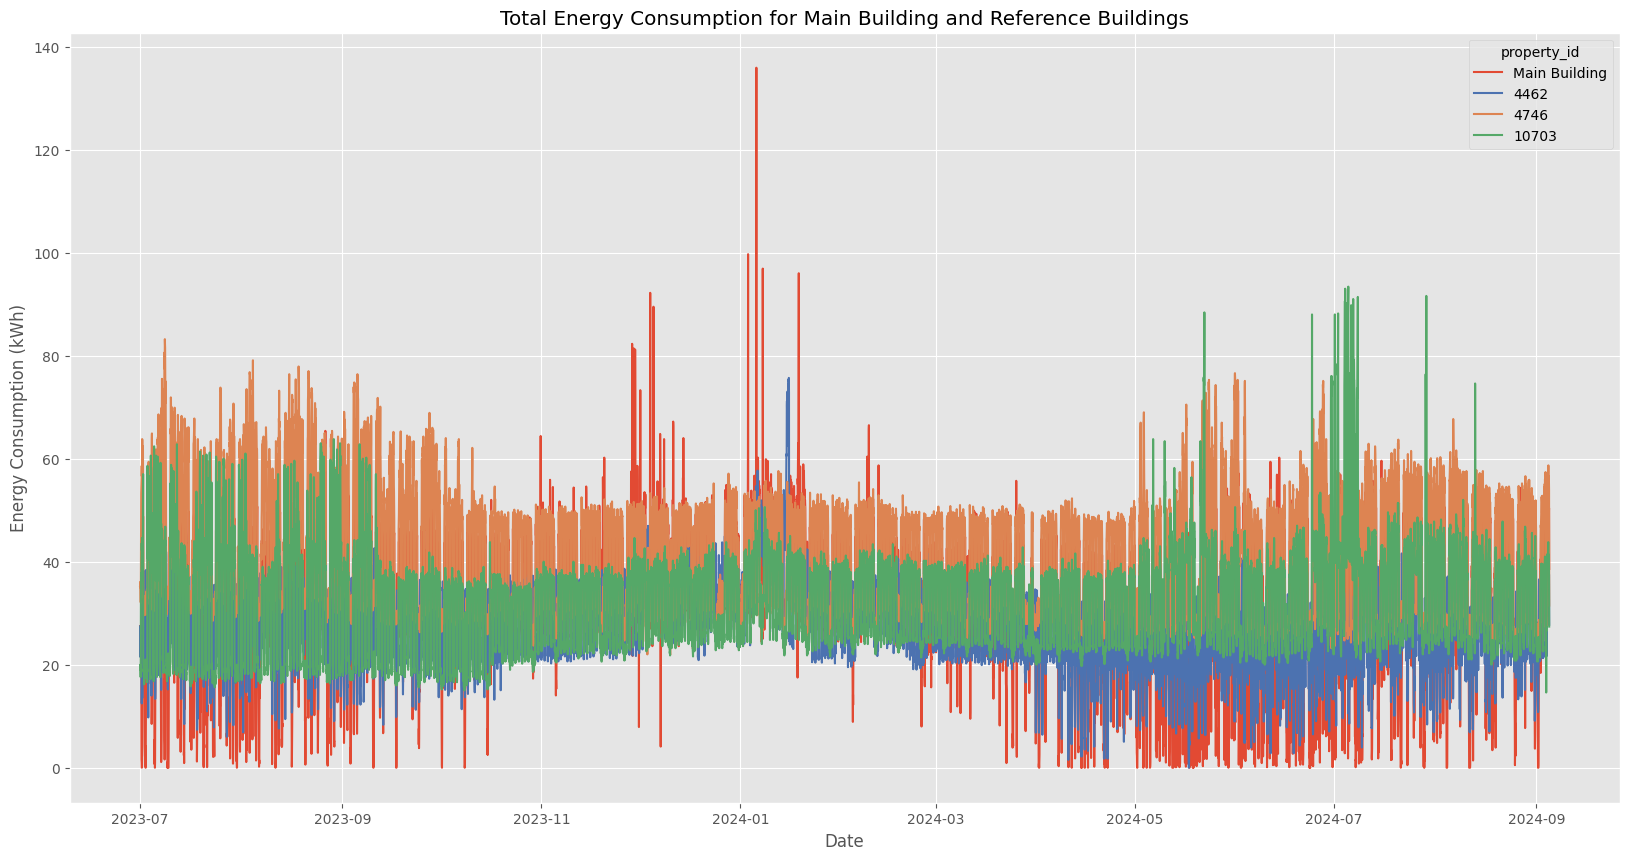

In [61]:
# Jeg ønsker å grafe energibruken til de forskjellige bygningene
# Plot total energy consumption for main building and reference buildings
plt.figure(figsize=(20,10))
sns.lineplot(data=main_building_df, x='timestamp', y='value', label='Main Building')
sns.lineplot(data=ref_buildings_df, x='timestamp', y='value', hue='property_id', palette='deep')
plt.title('Total Energy Consumption for Main Building and Reference Buildings')
plt.ylabel('Energy Consumption (kWh)')
plt.xlabel('Date')
plt.show()

#Fra plottet legger jeg merke til to ting:
#1. hovedbygningen har lavere energiforbrukstopper i mars-oktober
#2. Hovedbygningen har helt klart høyere topper i vintermånedene

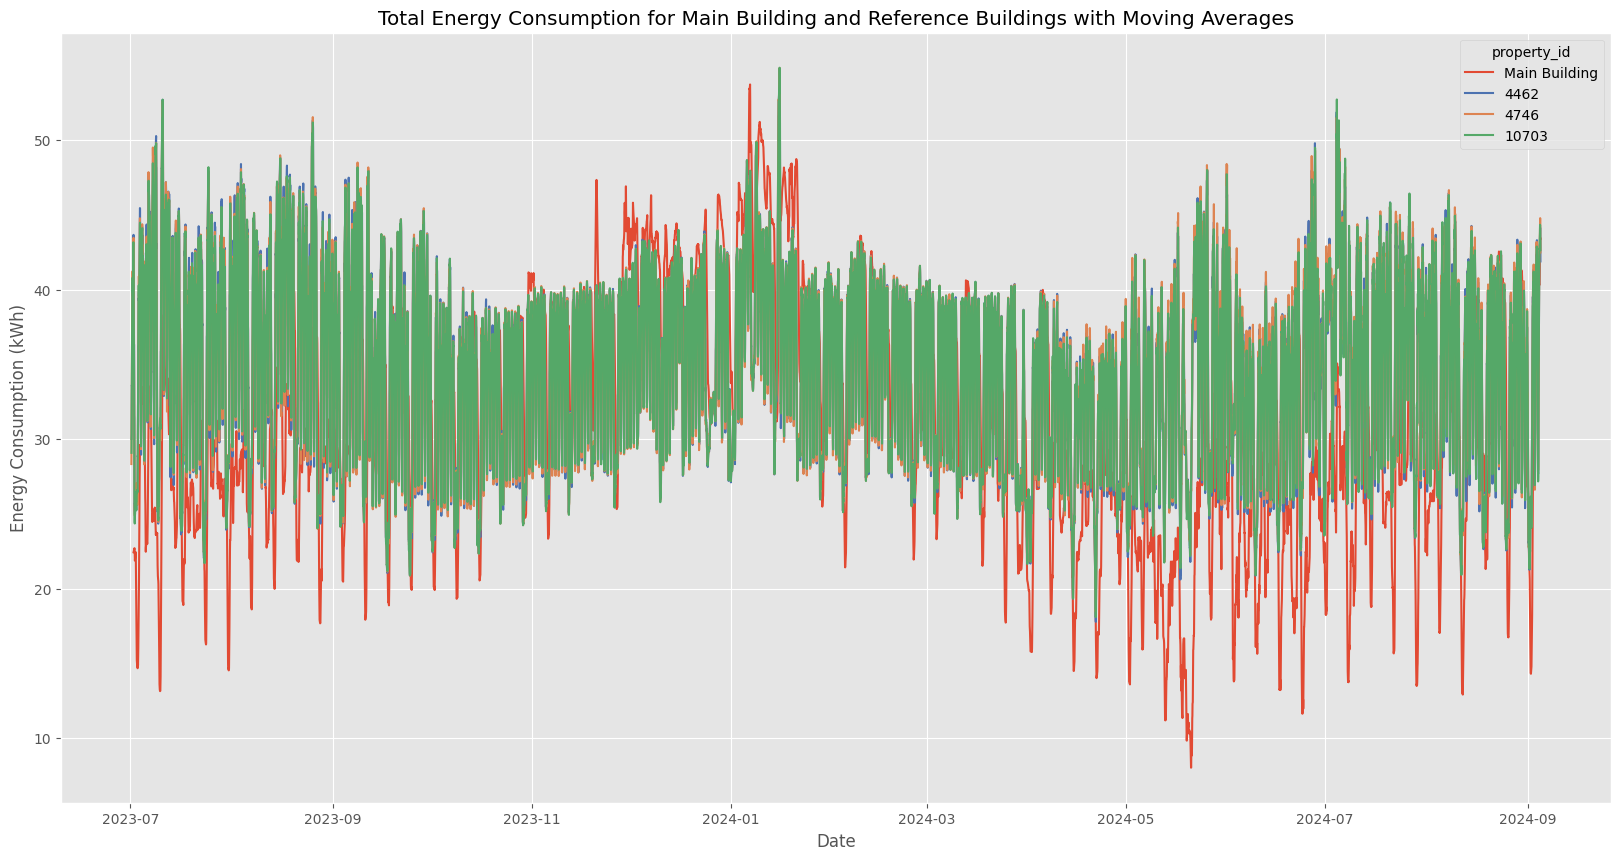

In [56]:
# Jeg prøver å plotte dataen igjen, men denne gangen med moving averages for å se om det gir et bedre bilde
# Plot total energy consumption for main building and reference buildings with moving averages
#Bruker et vindu på 24 timer for moving average
main_building_df['value_moving_average'] = main_building_df['value'].rolling(window=24).mean()
ref_buildings_df['value_moving_average'] = ref_buildings_df['value'].rolling(window=24).mean()

plt.figure(figsize=(20,10))
sns.lineplot(data=main_building_df, x='timestamp', y='value_moving_average', label='Main Building')
sns.lineplot(data=ref_buildings_df, x='timestamp', y='value_moving_average', hue='property_id', palette='deep')
plt.title('Total Energy Consumption for Main Building and Reference Buildings with Moving Averages')
plt.ylabel('Energy Consumption (kWh)')
plt.xlabel('Date')
plt.show()

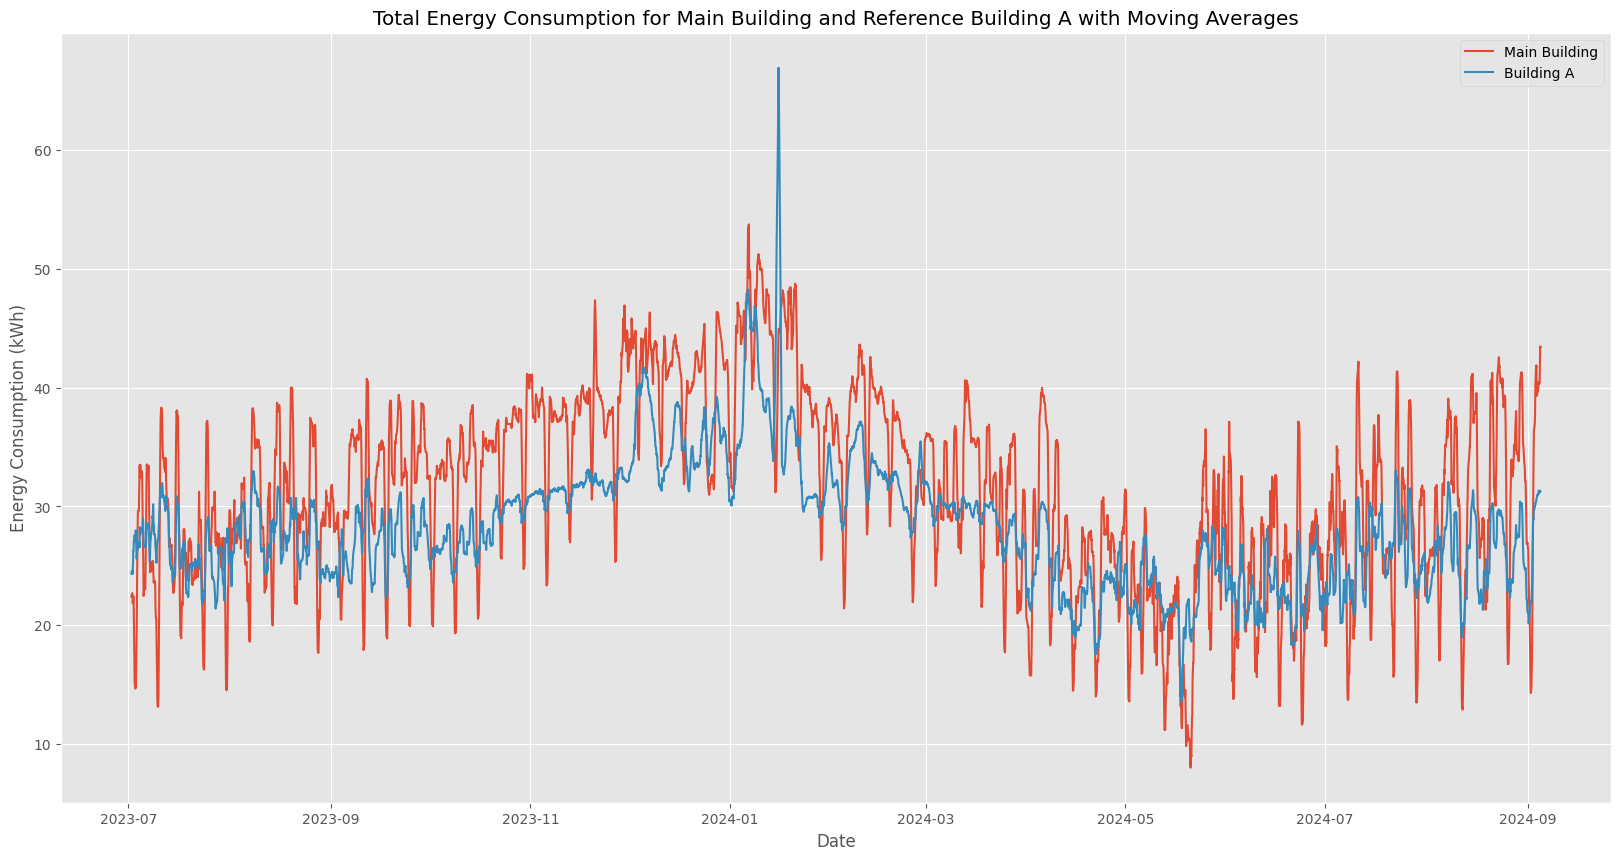

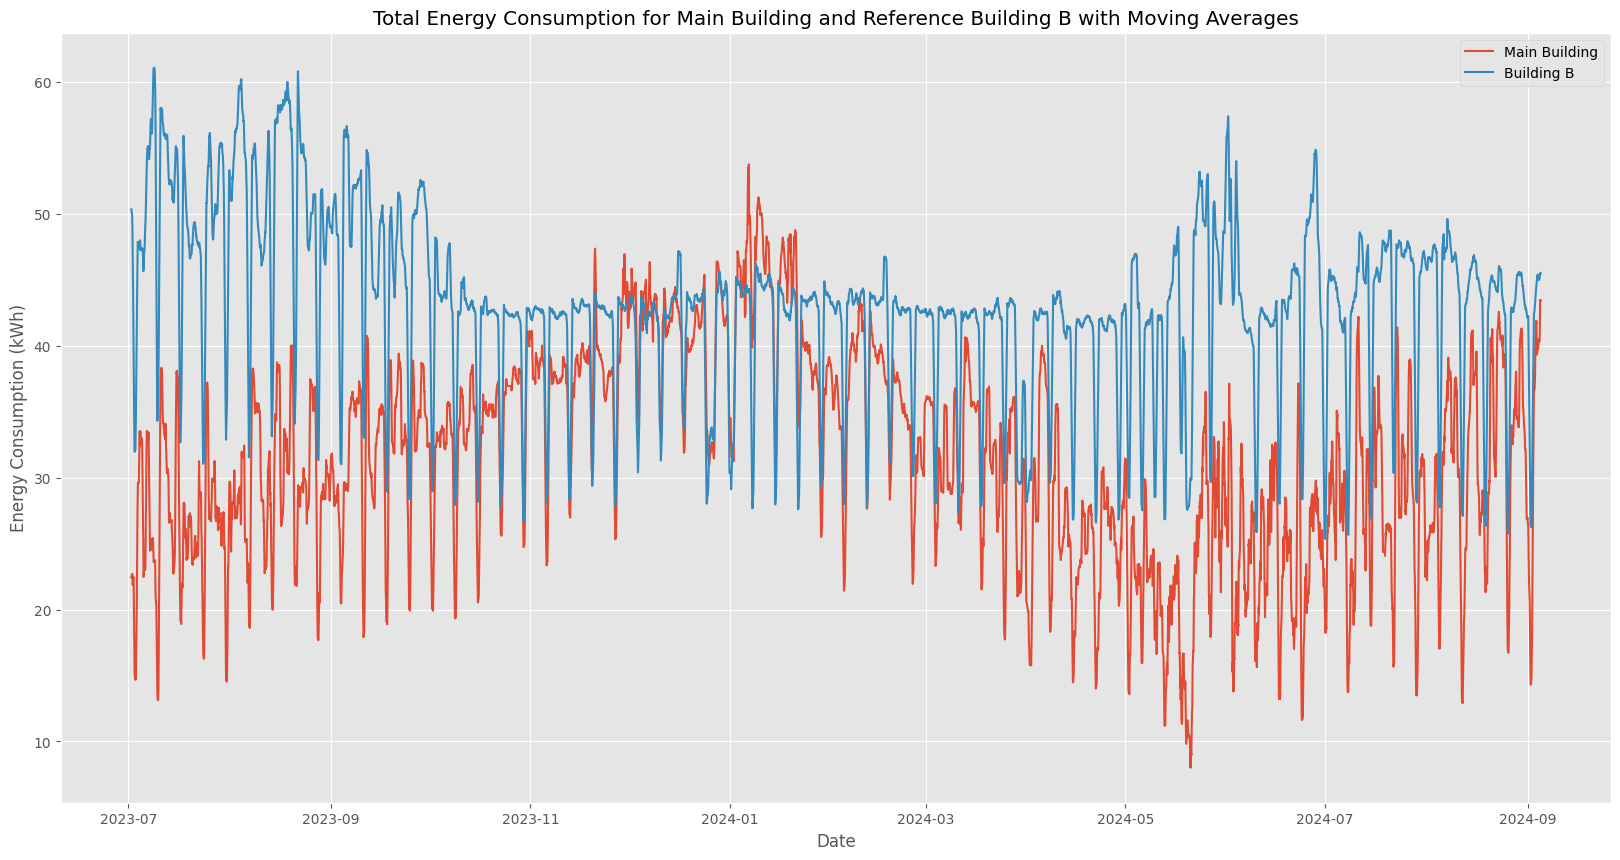

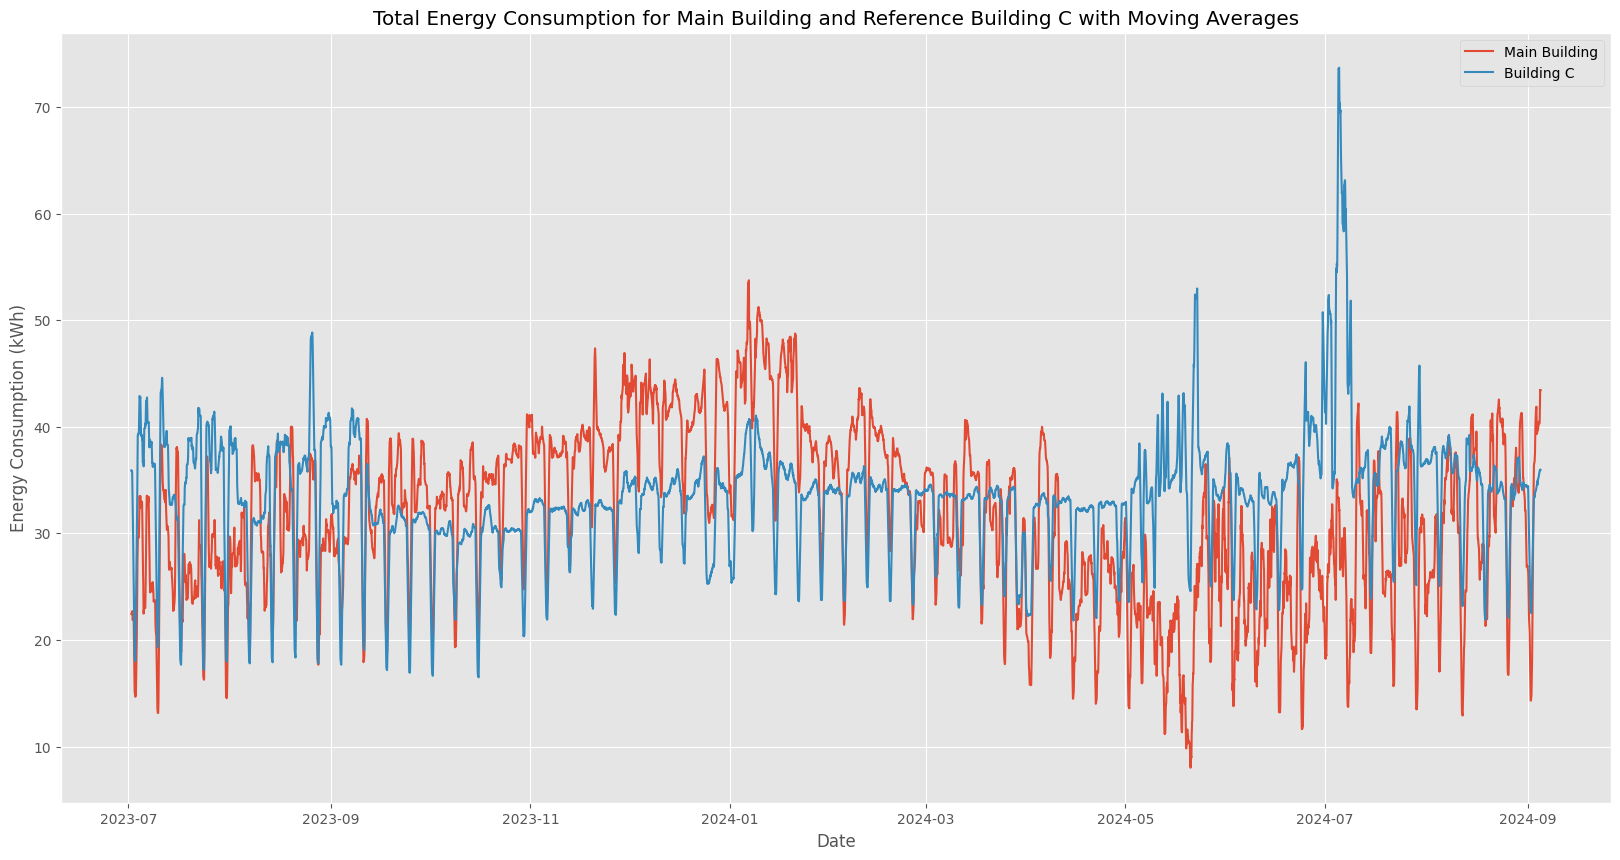

In [59]:
#Prøver igjen, men denne gangen kun med en av referansebygningene
ref_A_df = ref_buildings_df[ref_buildings_df['property_id'] == 4462]
ref_B_df = ref_buildings_df[ref_buildings_df['property_id'] == 4746]
ref_C_df = ref_buildings_df[ref_buildings_df['property_id'] == 10703]

ref_A_df['value_moving_average'] = ref_A_df['value'].rolling(window=24).mean()
ref_B_df['value_moving_average'] = ref_B_df['value'].rolling(window=24).mean()
ref_C_df['value_moving_average'] = ref_C_df['value'].rolling(window=24).mean()

#Bygning A
plt.figure(figsize=(20,10))
sns.lineplot(data=main_building_df, x='timestamp', y='value_moving_average', label='Main Building')
sns.lineplot(data=ref_A_df, x='timestamp', y='value_moving_average', label = 'Building A')
plt.title('Total Energy Consumption for Main Building and Reference Building A with Moving Averages')
plt.ylabel('Energy Consumption (kWh)')
plt.xlabel('Date')
plt.show()

#Bygning B
plt.figure(figsize=(20,10))
sns.lineplot(data=main_building_df, x='timestamp', y='value_moving_average', label='Main Building')
sns.lineplot(data=ref_B_df, x='timestamp', y='value_moving_average', label = 'Building B')
plt.title('Total Energy Consumption for Main Building and Reference Building B with Moving Averages')
plt.ylabel('Energy Consumption (kWh)')
plt.xlabel('Date')
plt.show()

#Bygning C
plt.figure(figsize=(20,10))
sns.lineplot(data=main_building_df, x='timestamp', y='value_moving_average', label='Main Building')
sns.lineplot(data=ref_C_df, x='timestamp', y='value_moving_average', label = 'Building C')
plt.title('Total Energy Consumption for Main Building and Reference Building C with Moving Averages')
plt.ylabel('Energy Consumption (kWh)')
plt.xlabel('Date')
plt.show()

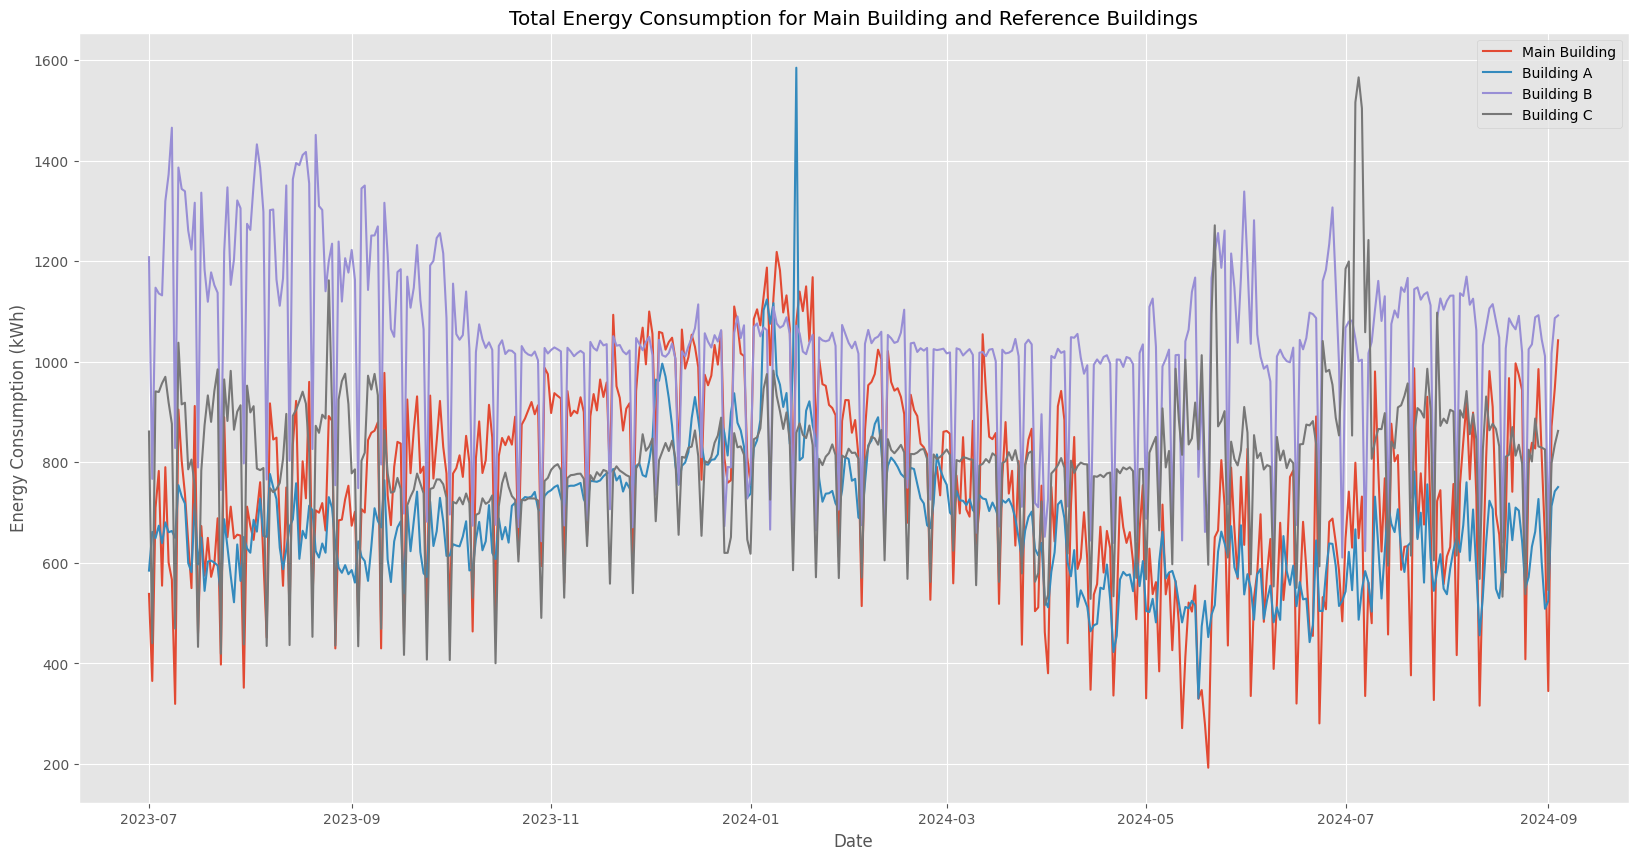

In [63]:
# Prøver på nytt hvor vi grupperer dataen og plotter totalverdiene for hver dag, istedenfor time for time
# Group data by date and calculate total energy consumption for each day
main_building_daily_df = main_building_df.groupby(main_building_df['timestamp'].dt.date)['value'].sum().reset_index()
ref_A_daily_df = ref_A_df.groupby(ref_A_df['timestamp'].dt.date)['value'].sum().reset_index()
ref_B_daily_df = ref_B_df.groupby(ref_B_df['timestamp'].dt.date)['value'].sum().reset_index()
ref_C_daily_df = ref_C_df.groupby(ref_C_df['timestamp'].dt.date)['value'].sum().reset_index()

# Plot total energy consumption for main building and reference buildings
plt.figure(figsize=(20,10))
sns.lineplot(data=main_building_daily_df, x='timestamp', y='value', label='Main Building')
sns.lineplot(data=ref_A_daily_df, x='timestamp', y='value', label = 'Building A')
sns.lineplot(data=ref_B_daily_df, x='timestamp', y='value', label = 'Building B')
sns.lineplot(data=ref_C_daily_df, x='timestamp', y='value', label = 'Building C')
plt.title('Total Energy Consumption for Main Building and Reference Buildings')
plt.ylabel('Energy Consumption (kWh)')
plt.xlabel('Date')
plt.show()


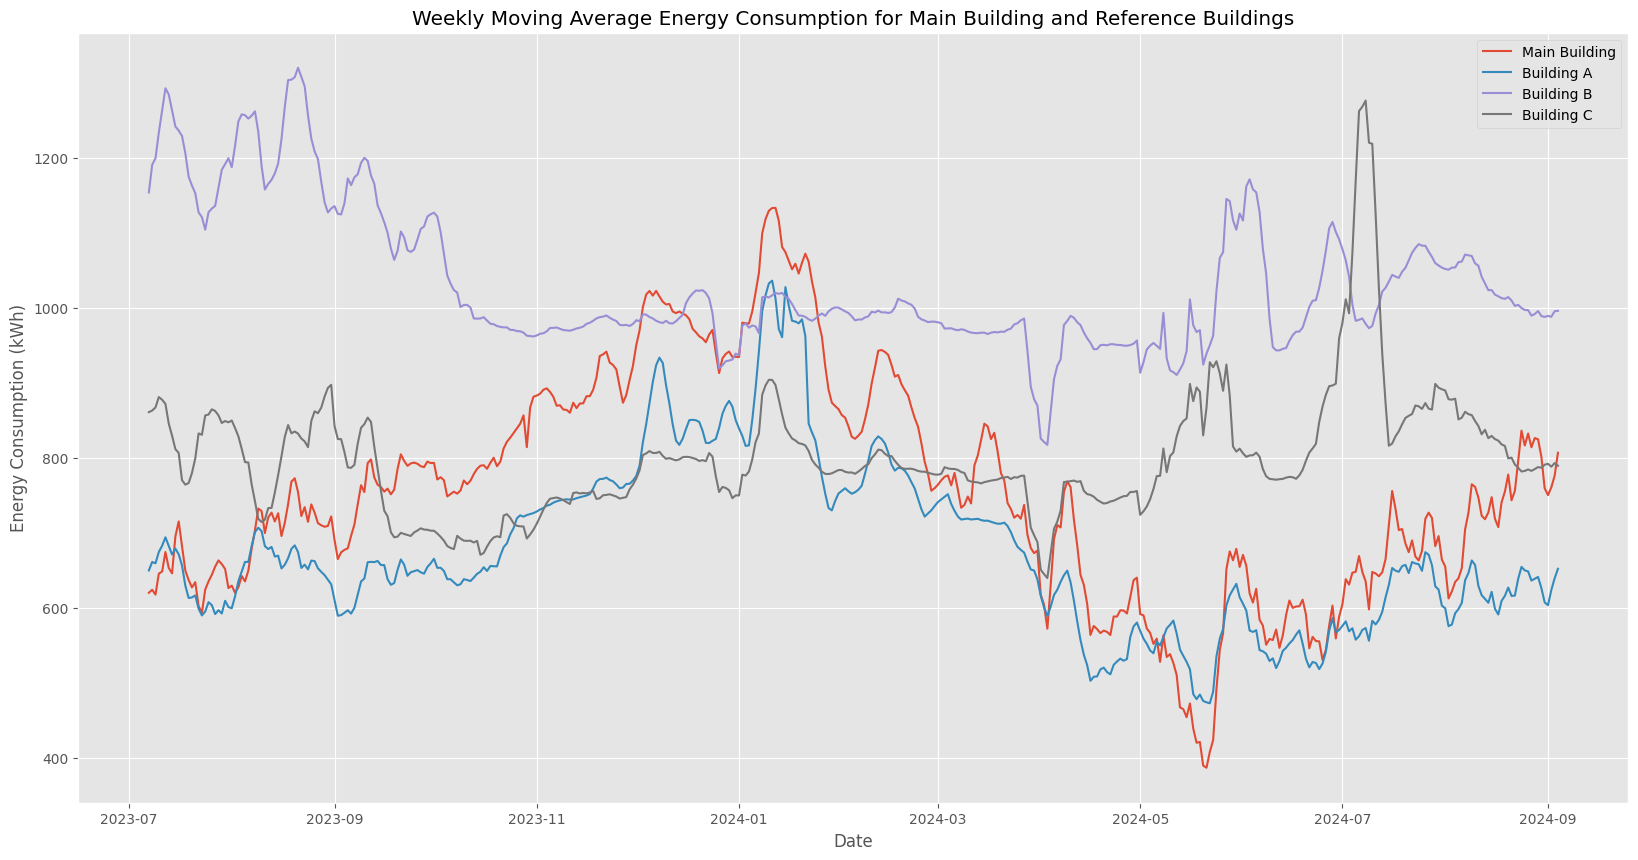

In [65]:
#Plotter ukentlig moving average for hovedbygningen og referansebygningene
# Calculate weekly moving average
main_building_daily_df['value_moving_average'] = main_building_daily_df['value'].rolling(window=7).mean()
ref_A_daily_df['value_moving_average'] = ref_A_daily_df['value'].rolling(window=7).mean()
ref_B_daily_df['value_moving_average'] = ref_B_daily_df['value'].rolling(window=7).mean()
ref_C_daily_df['value_moving_average'] = ref_C_daily_df['value'].rolling(window=7).mean()

# Plot weekly moving average for main building and reference buildings
plt.figure(figsize=(20,10))
sns.lineplot(data=main_building_daily_df, x='timestamp', y='value_moving_average', label='Main Building')
sns.lineplot(data=ref_A_daily_df, x='timestamp', y='value_moving_average', label = 'Building A')
sns.lineplot(data=ref_B_daily_df, x='timestamp', y='value_moving_average', label = 'Building B')
sns.lineplot(data=ref_C_daily_df, x='timestamp', y='value_moving_average', label = 'Building C')
plt.title('Weekly Moving Average Energy Consumption for Main Building and Reference Buildings')
plt.ylabel('Energy Consumption (kWh)')
plt.xlabel('Date')
plt.show()


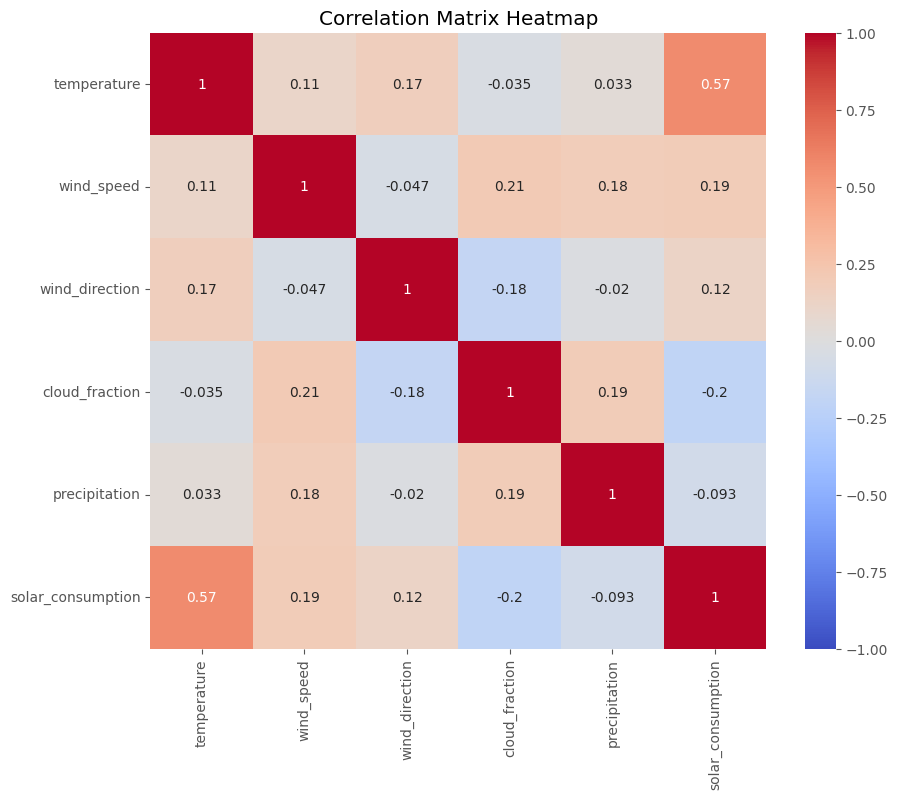

In [67]:
#Jeg ønsker nå å se etter sammenhenger med solforbruket og værdataen
# Generate the correlation matrix
correlation_matrix_solar = main_building_df[["temperature", "wind_speed", "wind_direction", "cloud_fraction", "precipitation", "solar_consumption"]].corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Create a heatmap of the correlation matrix
sns.heatmap(correlation_matrix_solar, annot=True, cmap='coolwarm', vmin=-1, vmax=1, square=True)
plt.title("Correlation Matrix Heatmap")
plt.show()

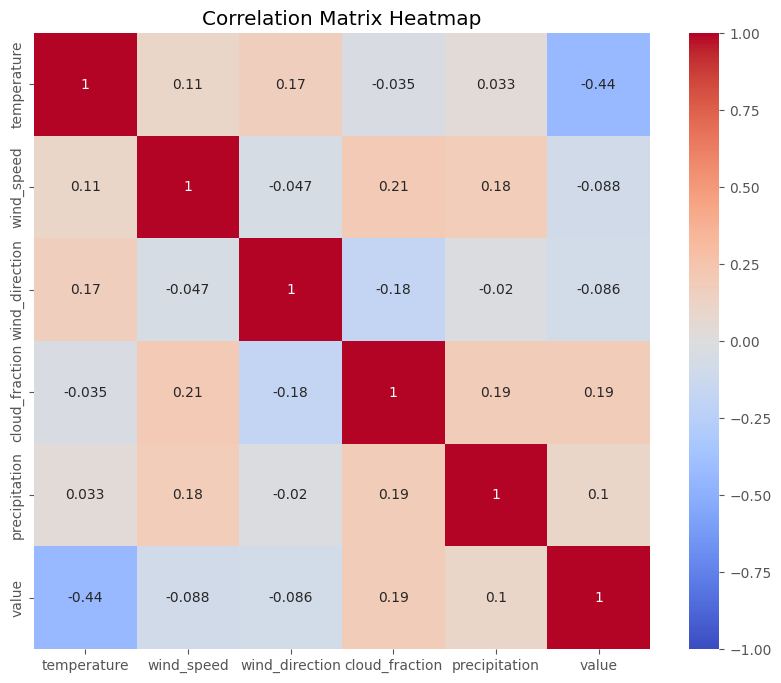

In [68]:
#Vi ser at den eneste merkverdige korrelasjonen er mellom temperatur og solforbruk.
#Det gir mening mtp at det er høyere temperaturer i solrike perioder
#Rart at skydekke ikke slår ut mer

# Jeg ønsker nå å se på sammenhengen mellom forbruket i hovedbygningen og været
correlation_matrix_value = main_building_df[["temperature", "wind_speed", "wind_direction", "cloud_fraction", "precipitation", "value"]].corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Create a heatmap of the correlation matrix
sns.heatmap(correlation_matrix_value, annot=True, cmap='coolwarm', vmin=-1, vmax=1, square=True)
plt.title("Correlation Matrix Heatmap")
plt.show()

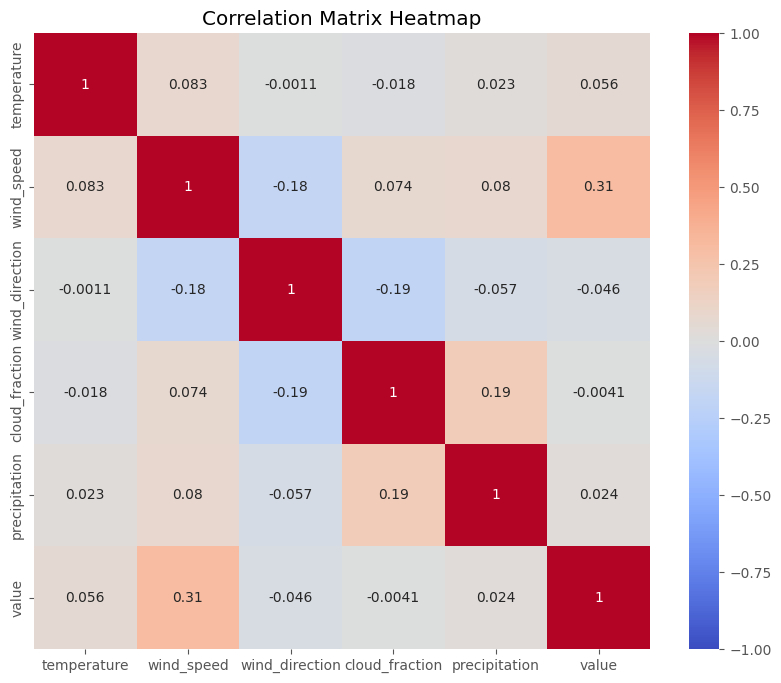

In [69]:
#Her også ser vi at været virker som den største påvirkeren på energiforbruket

#Jeg ønsker å sjekke opp dette med referansebyggene
#Er det samme korrelasjon mellom vær og energiforbruk for dem?
correlation_matrix_ref = ref_buildings_df[["temperature", "wind_speed", "wind_direction", "cloud_fraction", "precipitation", "value"]].corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Create a heatmap of the correlation matrix
sns.heatmap(correlation_matrix_ref, annot=True, cmap='coolwarm', vmin=-1, vmax=1, square=True)
plt.title("Correlation Matrix Heatmap")
plt.show()

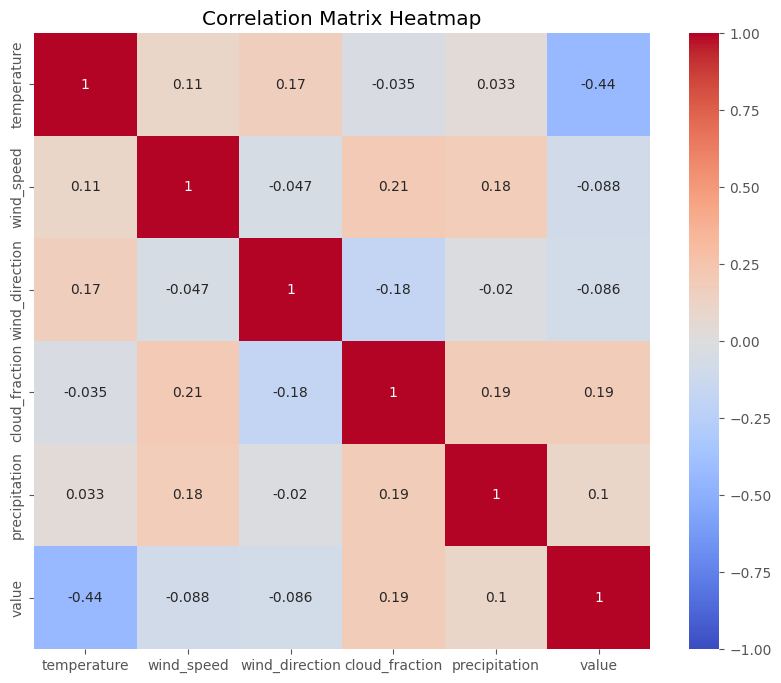

In [71]:
#Ser ut til at temperaturen nesten ikke har noe å si her.
#Rart at vindhsastighet har en så høy korrelasjon, enten random eller så er alle referansebyggene ved sjøen. idk
#Hypotese: Korrelasjonen vi ser mellom temperatur og energiforbruk i hovedbygningen skyldes mindre sol i sesongen, og dermed større andel
#importert energi. Dette må undersøkes mer
# Hvordan kan vi se på det faktiske forbruket av energi, ikke hva det importerer eller bruker av solenergi?

#Prøver å lage en ny kolonne som viser totalt forbruk av energi
main_building_df['adjusted_value'] = np.where(
    main_building_df['direction'] == 'export', 
    -main_building_df['value'], 
    main_building_df['value']
)

main_building_df['total_consumption'] = main_building_df['adjusted_value'] + main_building_df['solar_consumption']

#Plotter correlasjonsmatrisen på nytt
correlation_matrix_total_value = main_building_df[["temperature", "wind_speed", "wind_direction", "cloud_fraction", "precipitation", "total_consumption"]].corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Create a heatmap of the correlation matrix
sns.heatmap(correlation_matrix_value, annot=True, cmap='coolwarm', vmin=-1, vmax=1, square=True)
plt.title("Correlation Matrix Heatmap")
plt.show()


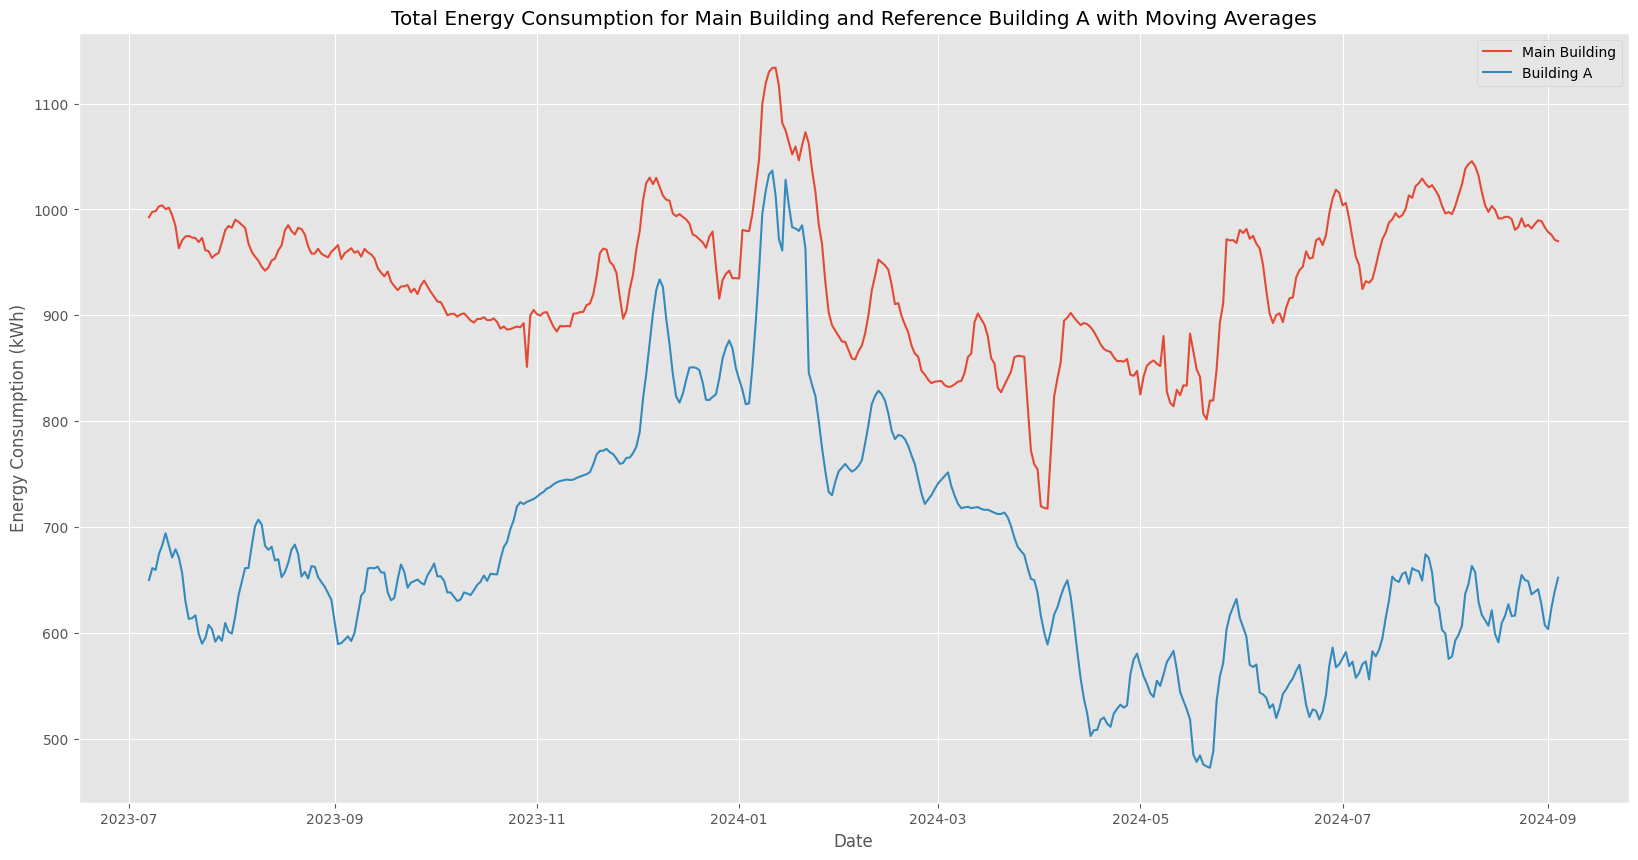

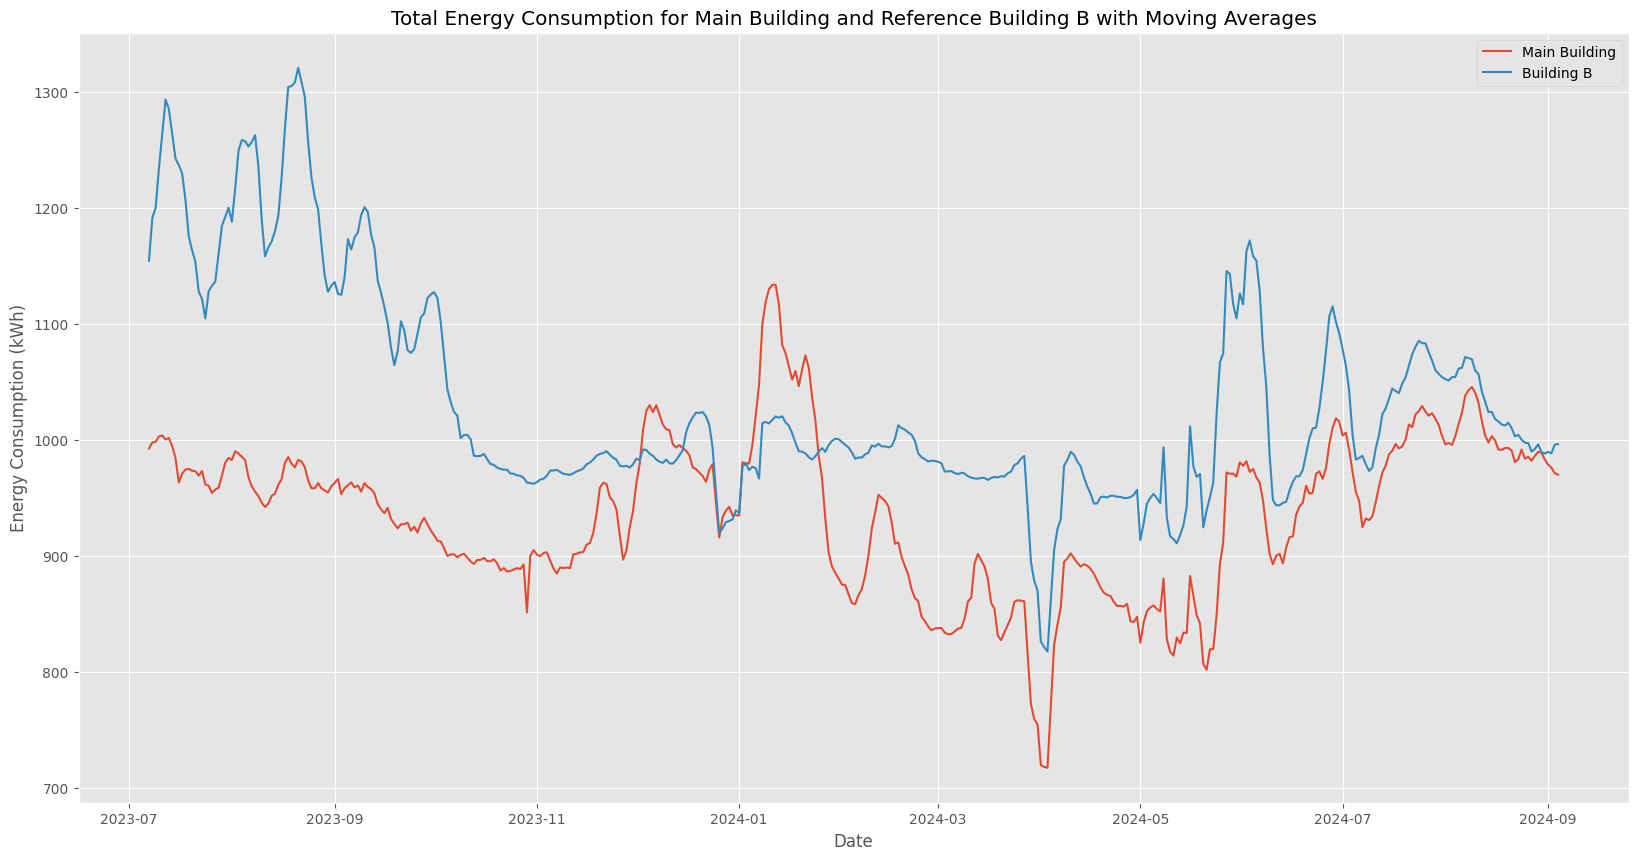

Text(0.5, 0, 'Date')

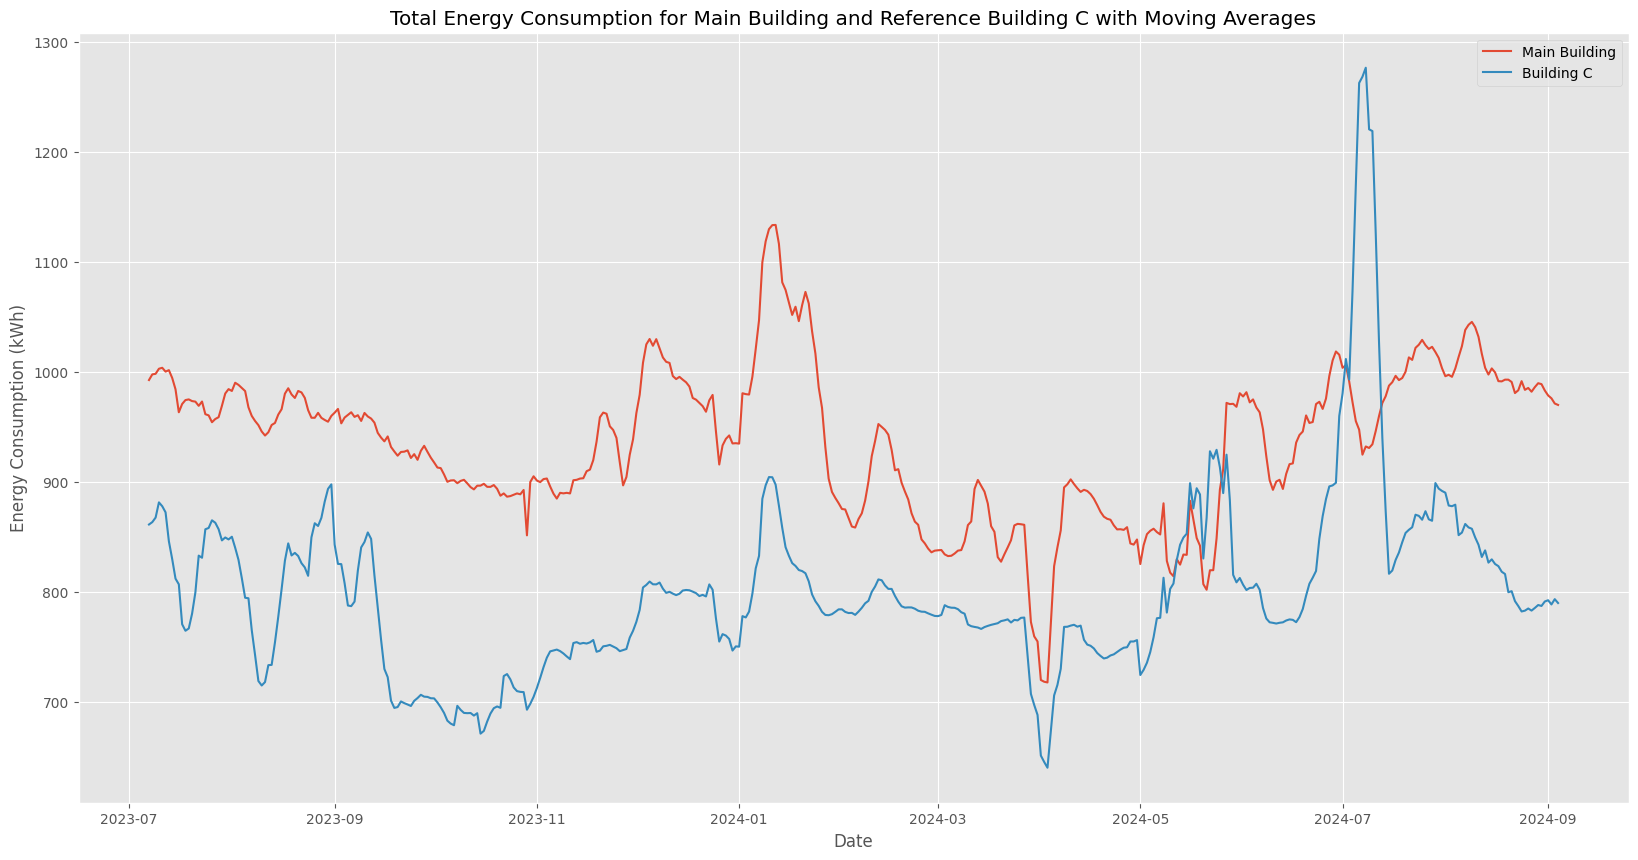

In [78]:
#Fortsatt en sammenheng mellom temperatur og energiforbruket

#Samler totalforbruket for en hel dag og lager en kolonne med ukentlig moving average
main_building_daily_total_df = main_building_df.groupby(main_building_df['timestamp'].dt.date)['total_consumption'].sum().reset_index()
main_building_daily_total_df['total_moving_average'] = main_building_daily_total_df['total_consumption'].rolling(window=7).mean()

#Ønsker å plotte totalforbruket for hovedbygningen mot referansebyggene
#Bygning A
plt.figure(figsize=(20,10))
sns.lineplot(data=main_building_daily_total_df, x='timestamp', y='total_moving_average', label='Main Building')
sns.lineplot(data=ref_A_daily_df, x='timestamp', y='value_moving_average', label = 'Building A')
plt.title('Total Energy Consumption for Main Building and Reference Building A with Moving Averages')
plt.ylabel('Energy Consumption (kWh)')
plt.xlabel('Date')
plt.show()

#Bygning B
plt.figure(figsize=(20,10))
sns.lineplot(data=main_building_daily_total_df, x='timestamp', y='total_moving_average', label='Main Building')
sns.lineplot(data=ref_B_daily_df, x='timestamp', y='value_moving_average', label = 'Building B')
plt.title('Total Energy Consumption for Main Building and Reference Building B with Moving Averages')
plt.ylabel('Energy Consumption (kWh)')
plt.xlabel('Date')
plt.show()

#Bygning C
plt.figure(figsize=(20,10))
sns.lineplot(data=main_building_daily_total_df, x='timestamp', y='total_moving_average', label='Main Building')
sns.lineplot(data=ref_C_daily_df, x='timestamp', y='value_moving_average', label = 'Building C')
plt.title('Total Energy Consumption for Main Building and Reference Building C with Moving Averages')
plt.ylabel('Energy Consumption (kWh)')
plt.xlabel('Date')

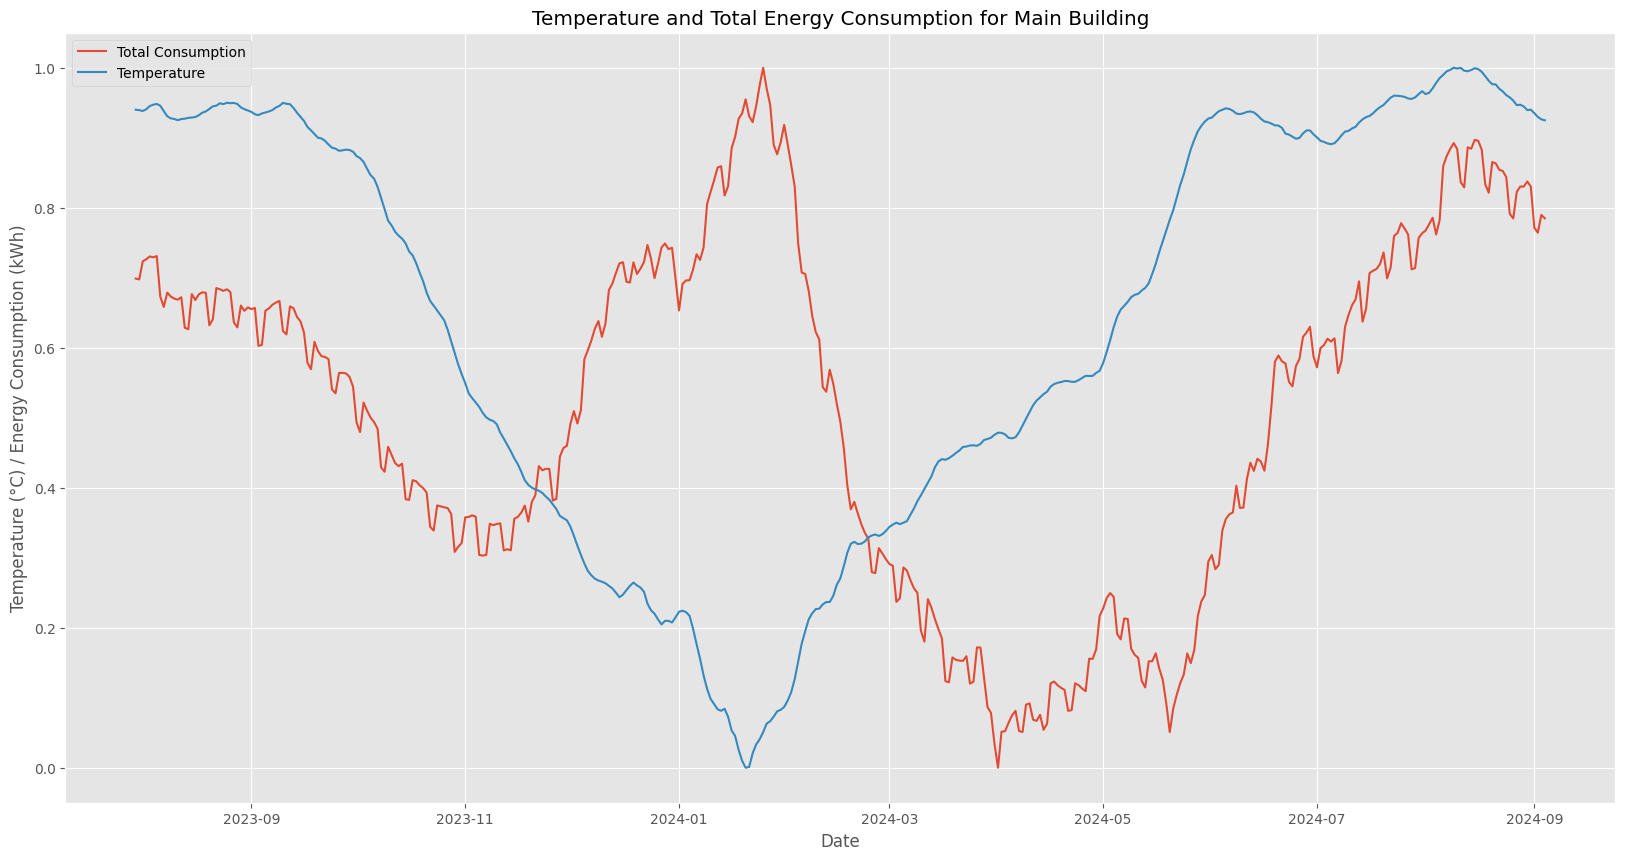

In [86]:
#Energiforbruket til hovedbygningen sin trend er generelt sett høyere enn referansebyggene
#Ikkje bra
#Siden det er spesielt stor korrelasjon mellom været og energiforbruket i hovedbygget, og tilnærmet ingen korrelasjon i referansebyggene
# Kan det virke som om hovedbygningen er dårlig isolert, og dermed er mer utsatt for sesongvariasjoner

# Lager en ny kolonne med daglig gjennomsnittstemperatur og ukentlig moving average
main_building_daily_temp_df = main_building_df.groupby(main_building_df['timestamp'].dt.date)['temperature'].mean().reset_index()
main_building_daily_temp_df['temp_moving_average'] = main_building_daily_temp_df['temperature'].rolling(window=30).mean()
main_building_daily_total_df['total_moving_average'] = main_building_daily_total_df['total_consumption'].rolling(window=30).mean()

#Normaliserer verdiene først
scaler = preprocessing.MinMaxScaler()
main_building_daily_temp_df['norm_temperature'] = scaler.fit_transform(main_building_daily_temp_df[['temp_moving_average']])
main_building_daily_total_df['norm_total_consumption'] = scaler.fit_transform(main_building_daily_total_df[['total_moving_average']])


#Ploter sesongvariasjonene i temperaturen, og totalforbruket til hovedbygningen
plt.figure(figsize=(20,10))
sns.lineplot(data=main_building_daily_total_df, x='timestamp', y='norm_total_consumption', label = 'Total Consumption')
sns.lineplot(data=main_building_daily_temp_df, x='timestamp', y='norm_temperature', label='Temperature')
plt.title('Temperature and Total Energy Consumption for Main Building')
plt.ylabel('Temperature (°C) / Energy Consumption (kWh)')
plt.xlabel('Date')
plt.show()

#Ser at det er en klar sammenheng mellom temperatur og energiforbruk